In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from tqdm import tqdm

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.png')
    plt.show()

In [3]:
df = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.loc[df.isFraud == 1].type.drop_duplicates().values

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [6]:
df = df[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

In [7]:
len(df)

2770409

# **Heuristico**

In [8]:
df['Fraud_Heuristic'] = np.where(((df['type'] == 'TRANSFER') & 
                                  (df['amount'] > 200000)),1,0)

In [9]:
df['Fraud_Heuristic'].sum()

409110

In [10]:
from sklearn.metrics import f1_score

In [11]:
f1_score(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])

0.013131315551742895

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
cm = confusion_matrix(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])

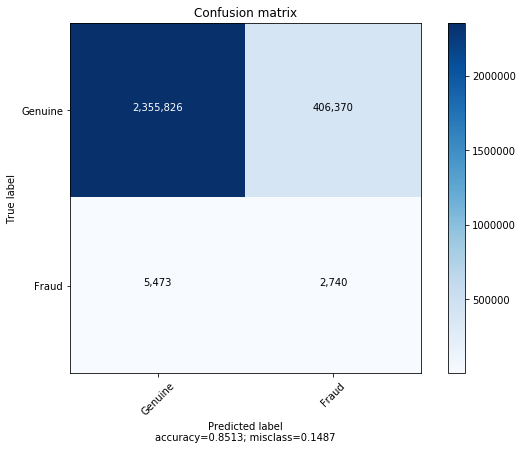

In [14]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [15]:
df.shape

(2770409, 12)

# **Caracteristicas**

In [16]:
#Con el modulo % sacamos residuos de una division
df['hour'] = df['step'] % 24

In [17]:
frauds = []
genuine = []
for i in range(24):
    f = len(df[(df['hour'] == i) & (df['isFraud'] == 1)])
    g = len(df[(df['hour'] == i) & (df['isFraud'] == 0)])
    frauds.append(f)
    genuine.append(g)

Observamos las proporciones de transacciones fraudulentas con respecto a la hora

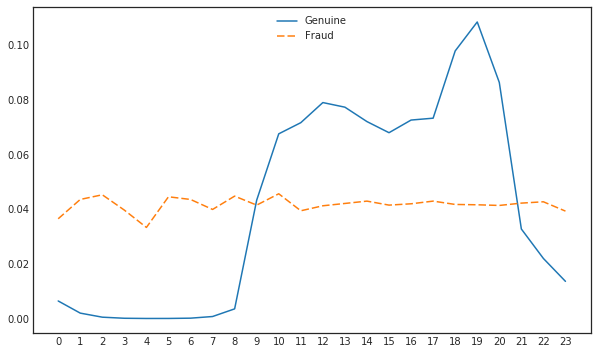

In [18]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
gen = ax.plot(genuine/np.sum(genuine), label='Genuine')
fr = ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time.png')

Proporcion fraud/genuine+fraud

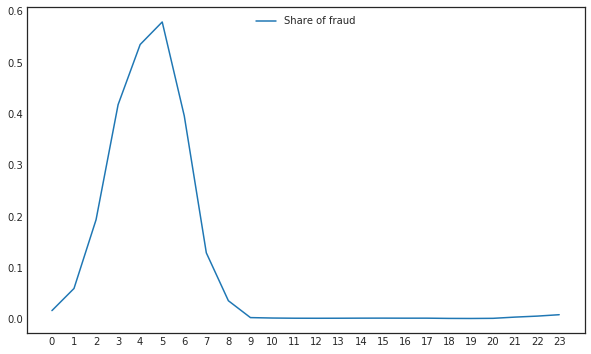

In [19]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
frgen = ax.plot(np.divide(frauds,np.add(genuine,frauds)), label='Share of fraud')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time_comp.png')

In [20]:
dfFraudTransfer = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]

In [21]:
dfFraudCashOut = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

In [22]:
dfFraudTransfer.nameDest.isin(dfFraudCashOut.nameOrig).any()

False

In [23]:
#dfNotFraud = df[(df.isFraud == 0)]

In [24]:
#dfFraud = df[(df.isFraud == 1)]

In [25]:
#dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]

In [26]:
#len(dfFraud[(dfFraud.oldBalanceDest == 0) & (dfFraud.newBalanceDest == 0) & (dfFraud.amount)]) / (1.0 * len(dfFraud))

In [27]:
#len(dfNotFraud[(dfNotFraud.oldBalanceDest == 0) & (dfNotFraud.newBalanceDest == 0) & (dfNotFraud.amount)]) / (1.0 * len(dfNotFraud))

In [28]:
dfOdd = df[(df.oldBalanceDest == 0) & 
           (df.newBalanceDest == 0) & 
           (df.amount)]

In [29]:
#Proporcion de fraudes en base al anterior filtro
len(dfOdd[(dfOdd.isFraud == 1)]) / len(dfOdd)

0.7046398891966759

In [30]:
#Proporcion de cuentas de origen con saldo insuficiente con base al monto de la accion bancaria 
len(dfOdd[(dfOdd.oldBalanceOrig <= dfOdd.amount)]) / len(dfOdd)

0.8966412742382271

In [31]:
len(dfOdd[(dfOdd.oldBalanceOrig <= dfOdd.amount) & (dfOdd.isFraud == 1)]) / len(dfOdd[(dfOdd.isFraud == 1)])

0.9636363636363636

Los fraudes se mueven en la madrugada y ademas, hay una peculiaridad y es que las cuentas a que se destinan siempre estan en cero. Otra peculiaridad es que se transfiere mas de lo que hay en las cuentas. Los hacker vacian mucho las cuentas mas que las personas normales.

In [32]:
#dfOdd.columns

In [33]:
#dfOdd.head(20)

In [34]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1


# **Preparacion de datos**

In [35]:
df['type'] = 'type_' + df['type'].astype(str)

In [36]:
# Get dummies
dummies = pd.get_dummies(df['type'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['type']

# **Predictive modeling with Keras**

In [37]:
df = df.drop(['nameOrig','nameDest','Fraud_Heuristic'], axis= 1)

In [38]:
df['isNight'] = np.where((2 <= df['hour']) & (df['hour'] <= 6), 1,0)

In [39]:
df[df['isNight'] == 1].isFraud.mean()

0.35705263157894734

In [40]:
df.head()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,hour,type_CASH_OUT,type_TRANSFER,isNight
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1,0,1,0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,1,0,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,1,0,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1,0,1,0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,0,1,0


In [41]:
df = df.drop(['step','hour'],axis=1)

In [42]:
df.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,isNight
2,181.00,181.0,0.0,0.0,0.00,1,0,0,1,0
3,181.00,181.0,0.0,21182.0,0.00,1,0,1,0,0
15,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,0,0
19,215310.30,705.0,0.0,22425.0,0.00,0,0,0,1,0
24,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,0,1,0


In [43]:
df.columns.values

array(['amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest',
       'newBalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT',
       'type_TRANSFER', 'isNight'], dtype=object)

In [44]:
y_df = df['isFraud']
x_df = df.drop('isFraud',axis=1)

In [45]:
y = y_df.values
X = x_df.values

In [46]:
y.shape

(2770409,)

In [47]:
X.shape

(2770409, 9)

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [51]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [52]:
#Para agregar mas muestras fraudulentas para que el modelo sea mas valido. Osea, hacemos un sobremuestreo.
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [54]:
# Log reg
model = Sequential()
model.add(Dense(1, input_dim=9))
model.add(Activation('sigmoid'))

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 10        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-5), 
              metrics=['acc'])

In [57]:
model.fit(X_train_res,y_train_res,
          epochs=5, 
          batch_size=256, 
          validation_data=(X_val,y_val))

Train on 3331258 samples, validate on 185618 samples
Epoch 1/5
3331258/3331258 [==============================] - 20s 6us/step - loss: 7.9678 - acc: 0.5000 - val_loss: 15.8799 - val_acc: 0.0039
Epoch 2/5
3331258/3331258 [==============================] - 19s 6us/step - loss: 7.9677 - acc: 0.5000 - val_loss: 15.8792 - val_acc: 0.0040
Epoch 3/5
3331258/3331258 [==============================] - 19s 6us/step - loss: 7.9676 - acc: 0.5000 - val_loss: 15.8794 - val_acc: 0.0039
Epoch 4/5
3331258/3331258 [==============================] - 19s 6us/step - loss: 7.9675 - acc: 0.5000 - val_loss: 15.8784 - val_acc: 0.0040
Epoch 5/5
3331258/3331258 [==============================] - 19s 6us/step - loss: 7.9674 - acc: 0.5000 - val_loss: 15.8781 - val_acc: 0.0040


In [58]:
y_pred = model.predict(X_test)

In [59]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [60]:
f1_score(y_pred=y_pred,y_true=y_test)

0.0059932469534327978

In [61]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

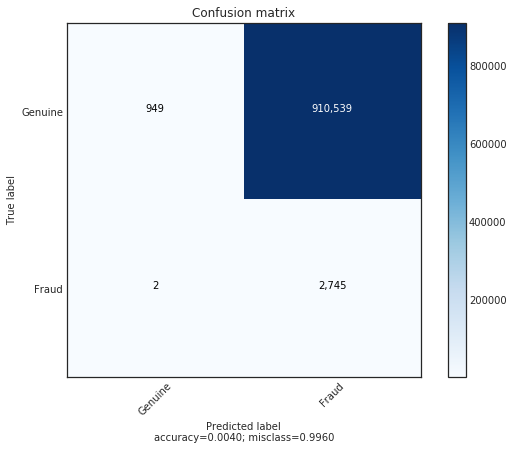

In [62]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [63]:
model = Sequential()
model.add(Dense(16,input_dim=9))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [64]:
model.compile(loss='binary_crossentropy',optimizer=SGD(lr=1e-4), metrics=['acc'])

In [65]:
model.fit(X_train_res,y_train_res,
          epochs=5, batch_size=256, 
          validation_data=(X_val,y_val))

Train on 3331258 samples, validate on 185618 samples
Epoch 1/5
3331258/3331258 [==============================] - 20s 6us/step - loss: 0.6970 - acc: 0.5714 - val_loss: 0.5926 - val_acc: 0.7978
Epoch 2/5
3331258/3331258 [==============================] - 20s 6us/step - loss: 0.5565 - acc: 0.8136 - val_loss: 0.5082 - val_acc: 0.7963
Epoch 3/5
3331258/3331258 [==============================] - 21s 6us/step - loss: 0.5002 - acc: 0.8139 - val_loss: 0.4662 - val_acc: 0.8010
Epoch 4/5
3331258/3331258 [==============================] - 20s 6us/step - loss: 0.5092 - acc: 0.8023 - val_loss: 0.5366 - val_acc: 0.8453
Epoch 5/5
3331258/3331258 [==============================] - 20s 6us/step - loss: 0.4728 - acc: 0.8480 - val_loss: 0.4153 - val_acc: 0.9802


In [66]:
y_pred = model.predict(X_test)

In [67]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [68]:
f1_score(y_pred=y_pred,y_true=y_test)

0.1785217430328053

In [69]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

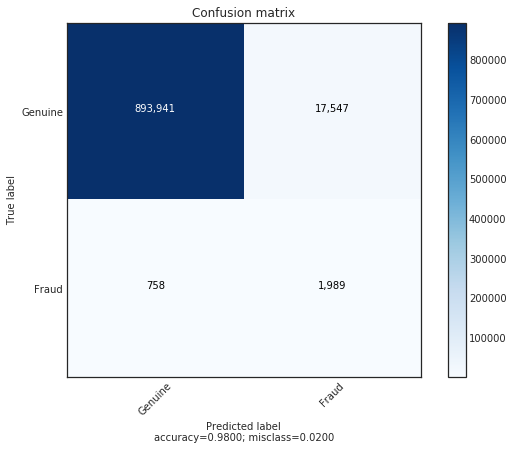

In [70]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

# Tree based methods

In [71]:
from sklearn.tree import export_graphviz

In [72]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

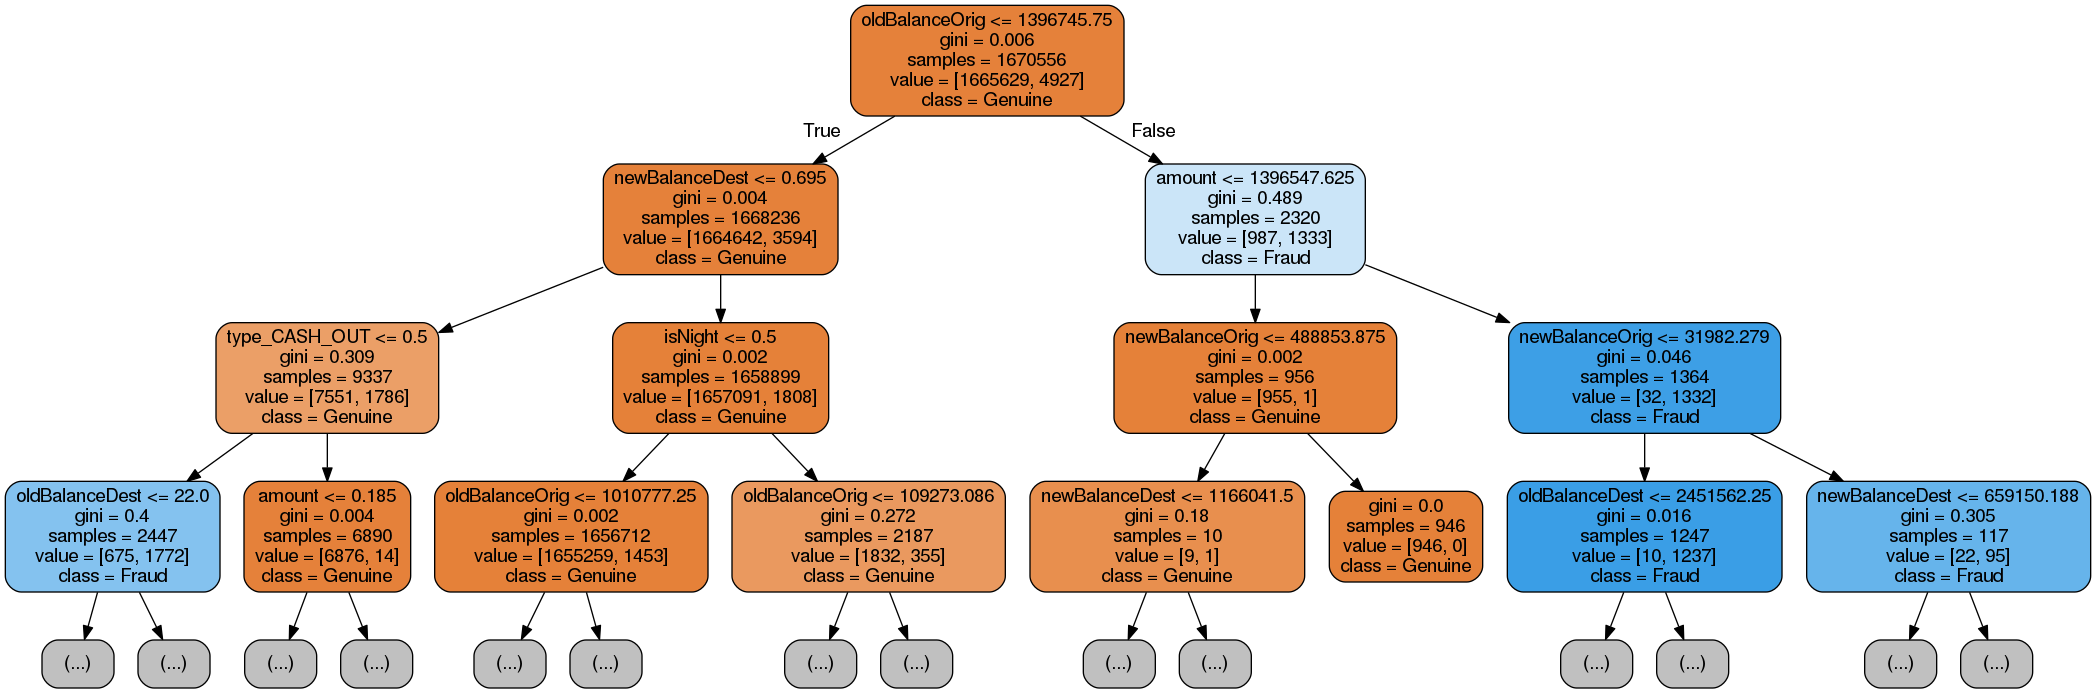

In [73]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

#import pydotplus
dot_data = StringIO()
'''export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)'''
with open("tree1.dot", 'w') as f:
     f = export_graphviz(dtree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(df.drop(['isFraud'], axis=1)),
                              class_names = ['Genuine', 'Fraud'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
img.save('sample-out.png')
PImage("sample-out.png")


In [74]:
from sklearn.ensemble import  RandomForestClassifier

In [75]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [76]:
y_pred = rf.predict(X_test)

In [77]:
f1_score(y_pred=y_pred,y_true=y_test)

0.87639553429027117

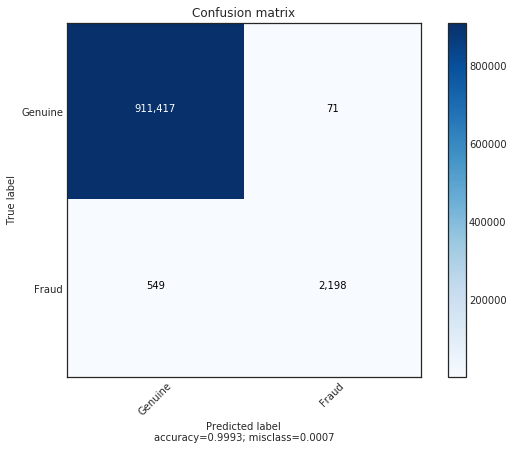

In [78]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [79]:
import xgboost as xgb

In [80]:
booster = xgb.XGBClassifier(n_jobs=-1)
booster = booster.fit(X_train,y_train)

In [81]:
y_pred = booster.predict(X_test)

In [82]:
f1_score(y_pred=y_pred,y_true=y_test)

0.85572959604286891

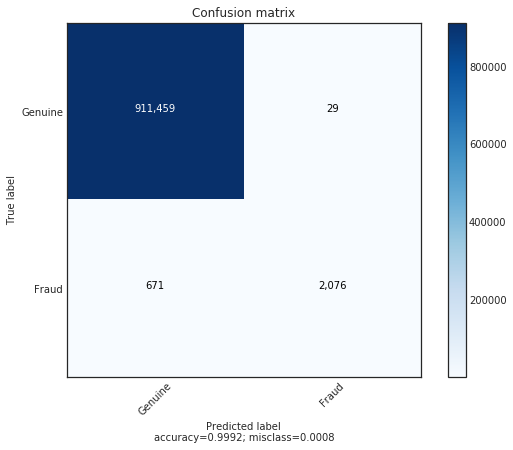

In [83]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

# Entity embeddings

In [84]:
# Reload data
df = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [85]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [86]:
df = df.drop(['nameDest','nameOrig','step'],axis=1)

In [87]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'], dtype=object)

In [88]:
map_dict = {}
for token, value in enumerate(df['type'].unique()):
    map_dict[value] = token   

In [89]:
map_dict

{'CASH_IN': 4, 'CASH_OUT': 2, 'DEBIT': 3, 'PAYMENT': 0, 'TRANSFER': 1}

In [90]:
df["type"].replace(map_dict, inplace=True)

In [91]:
df.head()

,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,0,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,0,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,2,181.00,181.0,0.00,21182.0,0.0,1,0
4,0,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [92]:
other_cols = [c for c in df.columns if ((c != 'type') and (c != 'isFraud'))]

In [93]:
other_cols

['amount',
 'oldBalanceOrig',
 'newBalanceOrig',
 'oldBalanceDest',
 'newBalanceDest',
 'isFlaggedFraud']

In [94]:
from keras.models import Model
from keras.layers import Embedding, Merge, Dense, Activation, Reshape, Input, Concatenate

In [95]:
num_types = len(df['type'].unique())
type_embedding_dim = 3

In [96]:
inputs = []
outputs = []

In [97]:
type_in = Input(shape=(1,))
type_embedding = Embedding(num_types,type_embedding_dim,input_length=1)(type_in)
type_out = Reshape(target_shape=(type_embedding_dim,))(type_embedding)

type_model = Model(type_in,type_out)

inputs.append(type_in)
outputs.append(type_out)

In [98]:
num_rest = len(other_cols)

In [99]:
rest_in = Input(shape = (num_rest,))
rest_out = Dense(16)(rest_in)

rest_model = Model(rest_in,rest_out)

inputs.append(rest_in)
outputs.append(rest_out)

In [100]:
concatenated = Concatenate()(outputs)

In [101]:
x = Dense(16)(concatenated)
x = Activation('sigmoid')(x)
x = Dense(1)(concatenated)
model_out = Activation('sigmoid')(x)

In [102]:
merged_model = Model(inputs, model_out)
merged_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])

In [103]:
types = df['type']

In [104]:
rest = df[other_cols]

In [105]:
target = df['isFraud']

In [106]:
history = merged_model.fit([types.values,rest.values],target.values, 
                           epochs = 1, batch_size = 128)

Epoch 1/1
6362620/6362620 [==============================] - 85s 13us/step - loss: 0.0637 - acc: 0.9960


In [107]:
merged_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 3)         15          input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3)            0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_4 (D